In [1]:
!nvidia-smi

Mon Jul  3 13:04:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download and Becoming One with the data

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-03 13:04:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 8.7s    

2023-07-03 13:04:23 (18.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

There are 2 directories and 0 files in 10_food_classes_10_percent
There are 10 directories and 0 files in 10_food_classes_10_percent/train
There are 0 directories and 75 files in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 files in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 files in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 files in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 files in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 files in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 files in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 files in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 files in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 files in 10_food_classes_10_percent/train/pizza
There are 10 directories and 0 fi

# Creating Data Loaders (preparing the data)

In [4]:

# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Tensorboard callback

In [5]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating model using Tensorflow Hub

In [6]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [12]:

# class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [13]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):

  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])

  plt.imshow(img)

  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape : {img.shape}")

  return img

Image shape : (341, 512, 3)


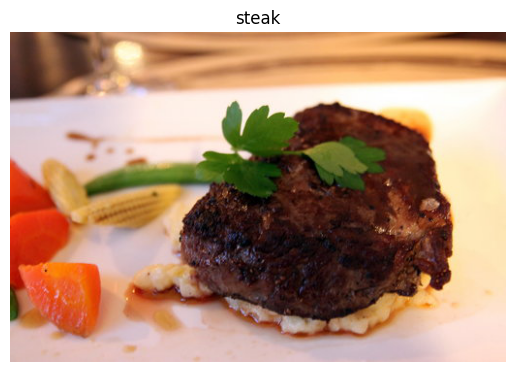

In [19]:
img = view_random_image(train_dir, 'steak')

In [20]:
def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it
  feature_extraction = hub.KerasLayer(model_url, trainable=False, name='feature_extraction', input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned pattern

  #Create our own model
  model = tf.keras.Sequential([
      feature_extraction,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model


### Creating REsNet TensorFlow Hub Feature extraction model

In [22]:
# Create REsnet model
resnet_model = create_model(resnet_url)

In [24]:
#Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 2048)             23564800  
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
resnet_history = resnet_model.fit(train_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data,
                             validation_steps=len(test_data),
                             callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                    experiment_name='resnet_v2_50')])

Saving TensorBoard log files to: tensorflow_hub/resnet_v2_50/20230703-134158
Epoch 1/5
24/24 [==============================] - 37s 881ms/step - loss: 1.9407 - accuracy: 0.3547 - val_loss: 1.2333 - val_accuracy: 0.5908
Epoch 2/5
24/24 [==============================] - 19s 798ms/step - loss: 0.9539 - accuracy: 0.7213 - val_loss: 0.8512 - val_accuracy: 0.7256
Epoch 3/5
24/24 [==============================] - 18s 793ms/step - loss: 0.6594 - accuracy: 0.8240 - val_loss: 0.7613 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 18s 770ms/step - loss: 0.5134 - accuracy: 0.8600 - val_loss: 0.7025 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 18s 783ms/step - loss: 0.4065 - accuracy: 0.9040 - val_loss: 0.6746 - val_accuracy: 0.7876


In [26]:

# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

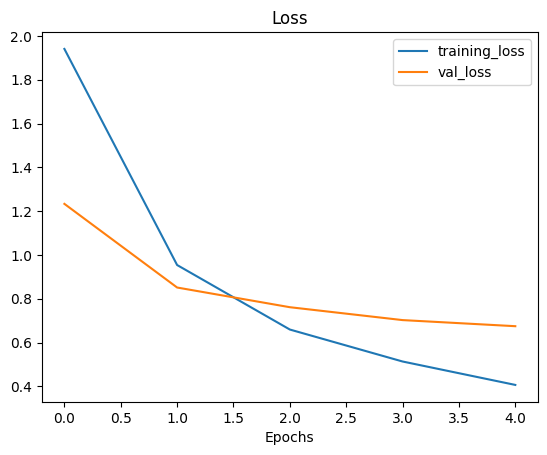

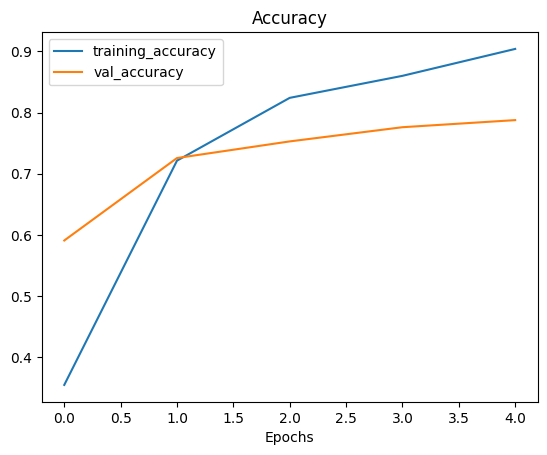

In [28]:
plot_loss_curves(resnet_history)

# Creating and testing EfficientNetB0 Tensorflow Hub Feature extraction model

In [37]:
efficient_net = create_model(efficientnet_url)

efficient_net.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [32]:
efficient_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 1280)             4049564   
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [38]:
efficientnet_history = efficient_net.fit(train_data_10_percent,
                  epochs=5,
                  steps_per_epoch=len(train_data_10_percent),
                  validation_data=test_data,
                  validation_steps=len(test_data),
                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficient_net_b0')])

Saving TensorBoard log files to: tensorflow_hub/efficient_net_b0/20230703-143401
Epoch 1/5
24/24 [==============================] - 28s 789ms/step - loss: 1.8345 - accuracy: 0.4440 - val_loss: 1.3114 - val_accuracy: 0.7196
Epoch 2/5
24/24 [==============================] - 16s 702ms/step - loss: 1.0615 - accuracy: 0.7907 - val_loss: 0.8726 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 16s 706ms/step - loss: 0.7592 - accuracy: 0.8413 - val_loss: 0.6981 - val_accuracy: 0.8480
Epoch 4/5
24/24 [==============================] - 18s 750ms/step - loss: 0.6063 - accuracy: 0.8680 - val_loss: 0.6092 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 17s 710ms/step - loss: 0.5106 - accuracy: 0.8893 - val_loss: 0.5604 - val_accuracy: 0.8664


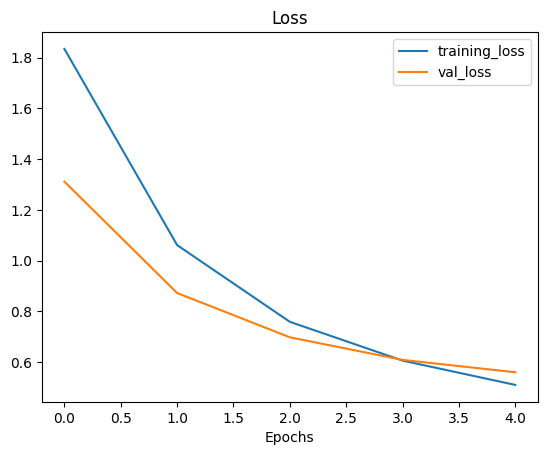

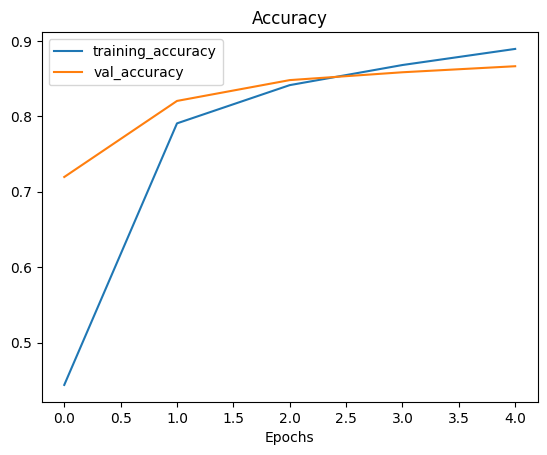

In [39]:
plot_loss_curves(efficientnet_history)

# Comparing our models results using TensorBoard

In [ ]:
# upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architecture" \
  --one_shot

https://tensorboard.dev/experiment/PV3G8MRKRBGjVXEDZGqwTQ/

In [42]:
!tensorboard dev list

2023-07-03 14:47:50.708177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/PV3G8MRKRBGjVXEDZGqwTQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture
	Id                   PV3G8MRKRBGjVXEDZGqwTQ
	Created              2023-07-03 14:42:52 (5 minutes ago)
	Updated              2023-07-03 14:42:59 (4 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  14077809
Total: 1 experiment(s)
